In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from glob import glob
from matplotlib import pyplot as plt
import seaborn as sns

RANDOM_SEED = 435
NUM_CLASSES = 5

## EDA

In [27]:
paths_to_tabels = glob('ds/*')

lengths = []

td = []
td_mean = []

for table in tqdm(paths_to_tabels):
    df = pd.read_csv(table)
    lengths.append(df.shape[0])
    td.append(df.TIME.to_list())
    td[-1] = [td[-1][i + 1] - td[-1][i] for i in range(len(td[-1]) - 1)]
    td_mean.append(np.mean(td[-1]))


print('Mean FPS:', 1/np.mean(td_mean))

  0%|          | 0/4 [00:00<?, ?it/s]


AttributeError: 'DataFrame' object has no attribute 'TIME'

In [28]:
names = [f'<{i*100}' for i in range(1, 11)]
snames = [f'<{i*10}' for i in range(1, 11)]
count = [0]*10
small_count = [0]*10

for i in lengths:
    count[i//100] += 1
    if i < 100:
        small_count[i//10] += 1

scount = sum(count)
lbls = [f'{i/scount*100:.1f}%({i})' for i in count]

sscount = sum(small_count)
slbls = [f'{i/sscount*100:.1f}%({i})' for i in small_count]

plt.style.use("bmh")

ZeroDivisionError: division by zero

Проверим длинну наших записей

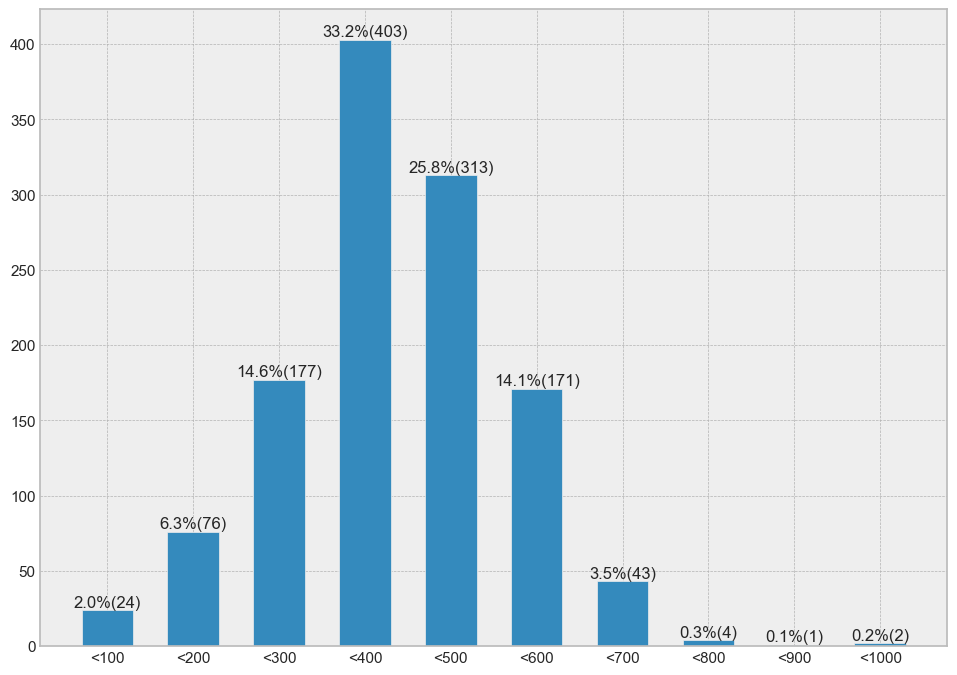

In [128]:
rects = plt.bar(names, count, width=0.6)
txt = plt.bar_label(rects, padding=0, labels=lbls)

In [5]:
df_meta = pd.read_csv('train.csv')

Классы по процентам

In [11]:
# Процентка по классам из Folder Path - типы заболевания
df_meta['Folder Path'].value_counts()/df_meta.shape[0]*100

Folder Path
Постуральный тремор           25.810324
кулак                         23.889556
постукивание пальцами         23.529412
кинетический тремор           19.447779
Пронация и супинация кисти     7.322929
Name: count, dtype: float64

Гистограмма возрастов (кол-во на каждый возраст) (0 - private данные)

<Axes: xlabel='полных лет', ylabel='count'>

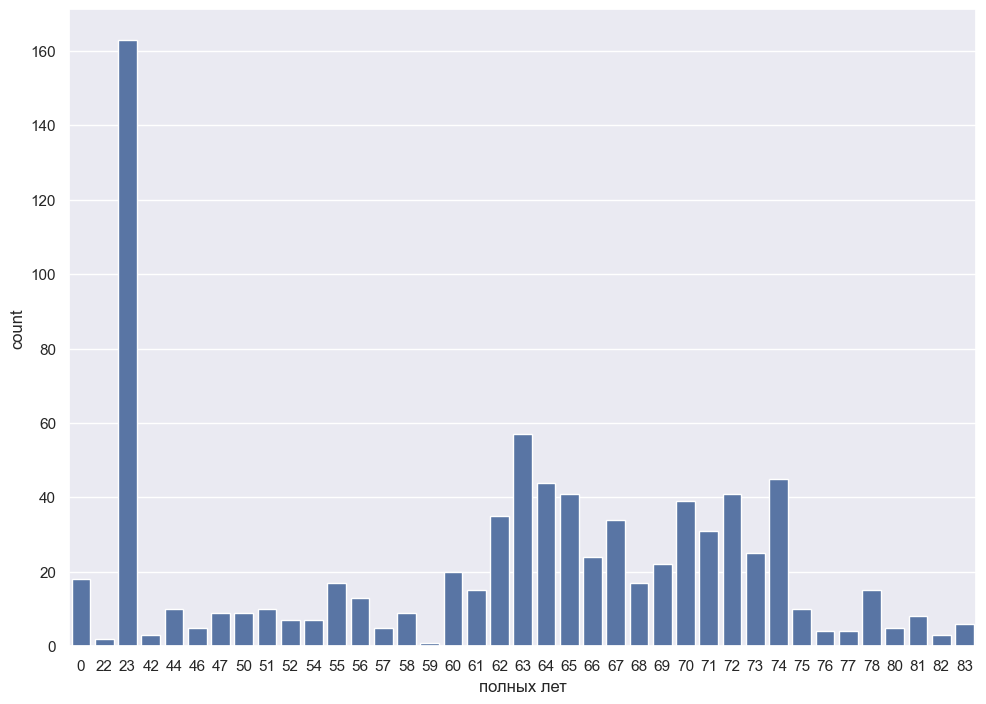

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(data=df_meta, x='полных лет', order=df_meta['полных лет'].value_counts().index.sort_values())

Распределение полов (в процентах)

In [13]:
df_meta['пол'].value_counts()/df_meta.shape[0]*100

пол
мужской    54.381753
женский    43.457383
0           2.160864
Name: count, dtype: float64

Состояние нейростимуляторов (в процентах) (нейростимуляторы - штука для отслуживания и лежечния с внешней стороны по импульсам)

In [14]:
df_meta['пациент off/on'].value_counts()/df_meta.shape[0]*100

пациент off/on
off    58.463385
on     41.536615
Name: count, dtype: float64

Степень по UPDRS

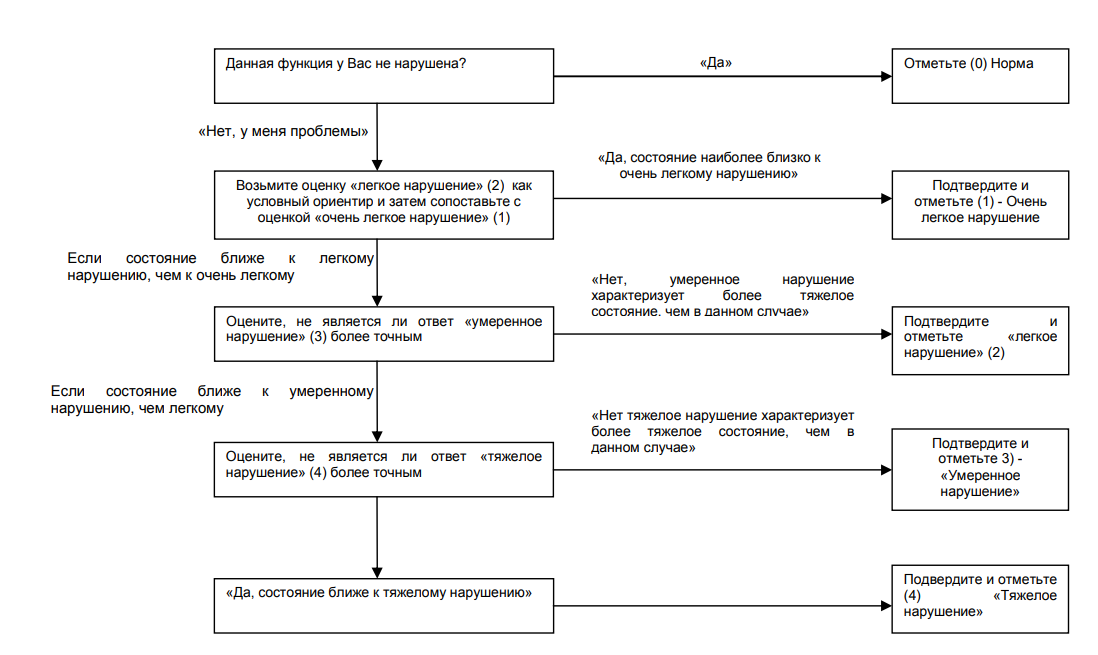

<Axes: xlabel='определенный диагноз врачом (0-5)'>

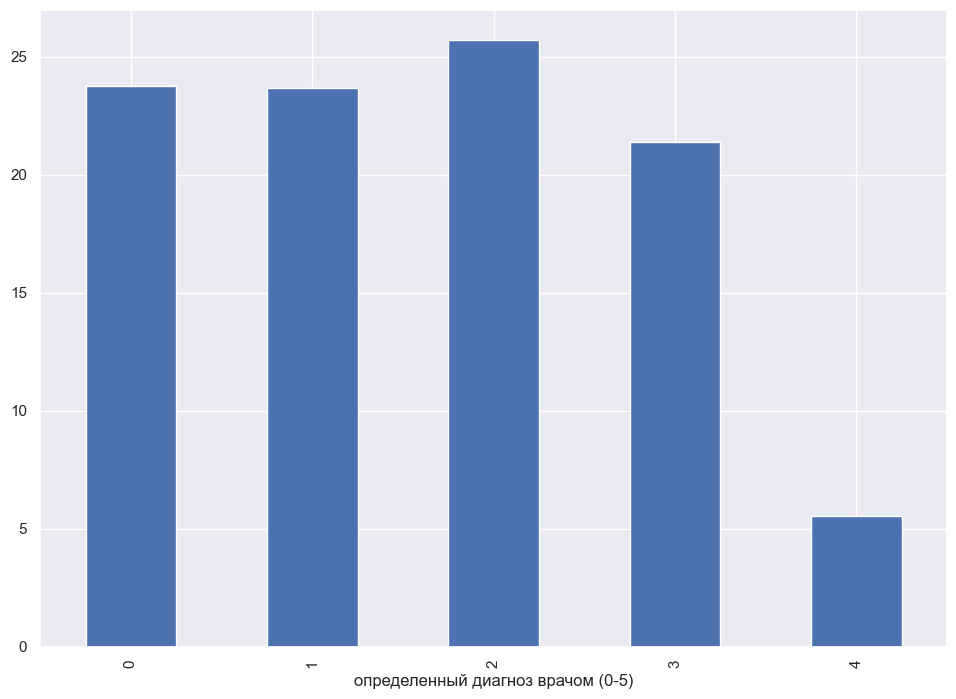

In [16]:
(df_meta['определенный диагноз врачом (0-5)'].value_counts().sort_index()/df_meta.shape[0]*100).plot(kind='bar')

## Data preprocessing

Подготовка данных. В первой ячейке формируем вектора для тренировок

In [38]:
meta_data = pd.read_csv(r'C:\Users\maxim\Desktop\SASHA\OSNOVNOE\PROGRANING\PYTHON\DOP\KODIIM\1)ML_prjt\zad1_NTOParcin\ds\train.csv')
moves = []
classes = []
gender = {'мужской': 1, 'женский': 0, '0': 2}
class_num = {meta_data['Folder Path'].unique()[i]: i  for i in range(5)}

meta_data['имя файла данных']

# for i in tqdm(range(meta_data.shape[0])):
#     temporary_data = pd.read_csv('data/' + meta_data['имя файла данных'][i])
#     temporary_meta = meta_data[['пол', 'полных лет', 'пациент off/on', 'определенный диагноз врачом (0-5)', 'Folder Path']][meta_data.index == i].values[0]
#     temporary_gender = gender[temporary_meta[0]]
#     classes.append(class_num[temporary_meta[4]])    
#     moves.append(np.append(temporary_data[:100].drop('TIME', axis=1).values.reshape(-1), [temporary_gender, temporary_meta[1], int(temporary_meta[2] == 'on'), temporary_meta[3]]))
    

0      raw_data_d786d645-db38-11ec-b494-e82aea2c97f4.csv
1      raw_data_bdcba44f-0d6a-11ed-8857-b6da2cf29e9d.csv
2      raw_data_750c0f09-b09a-11ec-9699-58a023d3f6d9.csv
3      raw_data_d90846c3-3969-11ed-a96d-b469216ca443.csv
4      raw_data_c27fbeb3-1882-11ed-95c1-b469216ca443.csv
                             ...                        
828    raw_data_e454ecdf-6fd9-11ed-8c3e-e82aea2c97f4.csv
829    raw_data_ed2a29d7-c16e-11ec-b4b8-e82aea2c97f4.csv
830    raw_data_f4a07d6b-64c3-11ed-aa07-e82aea2c97f4.csv
831    raw_data_c00aef37-0d5e-11ed-898c-80847c24eb6e.csv
832    raw_data_f3bb1bf3-1c63-11ed-8f50-b469216ca443.csv
Name: имя файла данных, Length: 833, dtype: object

In [136]:
X_train, X_test, y_train, y_test = train_test_split(np.asarray(moves), np.asarray(classes), train_size=0.75, random_state=RANDOM_SEED)

## Train

Инициализируем модель и настраиваем колбеки

In [3]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 3 * 100 + 4, )),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(48, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [4]:
model_save_path = 'last.hdf5'
best_model_save_path = 'best.hdf5'

In [6]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False) #сохранение каждой первой эпохи

es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=150, verbose=1) 
#остановка, если на 150 эпохах метрика на валидации не растёт

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=best_model_save_path,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True) #сохранение лучшей эпохи

tb_callback = tf.keras.callbacks.TensorBoard('./logs', update_freq=1) #инициализация tensorboard

ValueError: The filepath provided must end in `.keras` (Keras model format). Received: filepath=last.hdf5

In [140]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
) #сборка модели с оптимизатором Adam и метрикой accuracy

Запускаем обучение

In [141]:
model.fit(
    X_train,
    y_train,
    epochs=1500,
    batch_size=256,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback, tb_callback, model_checkpoint_callback]
)

Epoch 1/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.7521 - accuracy: 0.2188
Epoch 1: saving model to last.hdf5
3/3 [==============================] - 1s 106ms/step - loss: 1.6974 - accuracy: 0.2420 - val_loss: 1.6287 - val_accuracy: 0.2536
Epoch 2/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.6256 - accuracy: 0.2539
Epoch 2: saving model to last.hdf5
3/3 [==============================] - 0s 52ms/step - loss: 1.6330 - accuracy: 0.2372 - val_loss: 1.6000 - val_accuracy: 0.2823
Epoch 3/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.6368 - accuracy: 0.2383

C:\Users\a1az1\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: saving model to last.hdf5
3/3 [==============================] - 0s 52ms/step - loss: 1.6275 - accuracy: 0.2660 - val_loss: 1.6014 - val_accuracy: 0.3254
Epoch 4/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.5856 - accuracy: 0.3359
Epoch 4: saving model to last.hdf5
3/3 [==============================] - 0s 41ms/step - loss: 1.5946 - accuracy: 0.3189 - val_loss: 1.5902 - val_accuracy: 0.2249
Epoch 5/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.6057 - accuracy: 0.2930
Epoch 5: saving model to last.hdf5
3/3 [==============================] - 0s 41ms/step - loss: 1.5660 - accuracy: 0.2997 - val_loss: 1.5153 - val_accuracy: 0.2249
Epoch 6/1500
1/3 [=========>....................] - ETA: 0s - loss: 1.6260 - accuracy: 0.2617
Epoch 6: saving model to last.hdf5
3/3 [==============================] - 0s 52ms/step - loss: 1.5791 - accuracy: 0.3061 - val_loss: 1.4948 - val_accuracy: 0.4019
Epoch 7/1500
1/3 [=========>....................] - ETA: 0s - los

Выгрузка ответов

In [146]:
model = tf.keras.models.load_model('best.hdf5')

test_data = pd.read_csv('test.csv')
test_classes = []

num_to_class = {class_num[i] : i  for i in class_num.keys()}

preds = []

for i in tqdm(range(test_data.shape[0])):
    temporary_data = pd.read_csv('data/' + meta_data['имя файла данных'][i])
    temporary_meta = test_data[['пол', 'полных лет', 'пациент off/on', 'определенный диагноз врачом (0-5)']][test_data.index == i].values[0]
    temporary_gender = gender[temporary_meta[0]] 
    data_to_test = np.append(temporary_data[:100].drop('TIME', axis=1).values.reshape(-1), [temporary_gender, temporary_meta[1], int(temporary_meta[2] == 'on'), temporary_meta[3]])
    pred = model.predict(np.array([data_to_test]), verbose=False)
    preds.append(num_to_class[np.argmax(np.squeeze(pred))])

submit_to_send = pd.DataFrame({'path': test_data['имя файла данных'], 'pred': preds})
submit_to_send.to_csv('submit.csv', index=False)

100%|██████████| 357/357 [00:25<00:00, 14.15it/s]


In [150]:
import pandas as pd

df = pd.read_csv('platform.csv')

submit_to_send = pd.DataFrame({'path': df['имя файла данных'], 'pred': df['Folder Path']})
submit_to_send.to_csv('ideal.csv', index=False)